<a href="https://colab.research.google.com/github/rajcreo/credit-card-default-prediction-system/blob/main/CreditCardDefault.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Defaulter Prediction Model

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
import io

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, precision_score, recall_score


In [ ]:
train_uploaded = files.upload()
test_uploaded = files.upload()

Saving train.csv to train.csv


Saving test.csv to test.csv


In [ ]:
train = pd.read_csv(io.BytesIO(train_uploaded['train.csv']))
test = pd.read_csv(io.BytesIO(test_uploaded['test.csv']))

In [ ]:
test_id = test.iloc[:,0]
test_id

0        CST_142525
1        CST_129215
2        CST_138443
3        CST_123812
4        CST_144450
            ...    
11378    CST_142412
11379    CST_107967
11380    CST_134002
11381    CST_146856
11382    CST_112001
Name: customer_id, Length: 11383, dtype: object

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              45528 non-null  object 
 1   name                     45528 non-null  object 
 2   age                      45528 non-null  int64  
 3   gender                   45528 non-null  object 
 4   owns_car                 44981 non-null  object 
 5   owns_house               45528 non-null  object 
 6   no_of_children           44754 non-null  float64
 7   net_yearly_income        45528 non-null  float64
 8   no_of_days_employed      45065 non-null  float64
 9   occupation_type          45528 non-null  object 
 10  total_family_members     45445 non-null  float64
 11  migrant_worker           45441 non-null  float64
 12  yearly_debt_payments     45433 non-null  float64
 13  credit_limit             45528 non-null  float64
 14  credit_limit_used(%)  

In [ ]:
train.default_in_last_6months.unique()

array([1, 0])

In [ ]:
train.drop(['customer_id','name'], axis=1, inplace=True)

In [ ]:
test.drop(['customer_id','name'], axis=1, inplace=True)

In [ ]:
X_train = train.drop(['credit_card_default'], axis=1)
type(X_train)

pandas.core.frame.DataFrame

In [ ]:
y_train = train['credit_card_default']

In [ ]:
train_gender = train['gender']
train_car = train['owns_car']
train_house = train['owns_house']
train_occ = train['occupation_type']
train_num = X_train.drop(['gender', 'owns_car', 'owns_house', 'occupation_type'], axis=1)

test_gender = test['gender']
test_car = test['owns_car'] 
test_house = test['owns_house']
test_occ = test['occupation_type']
test_num = test.drop(['gender', 'owns_car', 'owns_house', 'occupation_type'], axis=1)

In [ ]:
gender_ord_encoder = OrdinalEncoder()

In [ ]:
train_gender_encoded = gender_ord_encoder.fit_transform(train_gender.values.reshape(-1, 1))

In [ ]:
gender_ord_encoder.categories_

[array(['F', 'M', 'XNA'], dtype=object)]

In [ ]:
car_ord_encoder = OrdinalEncoder()
train_car_encoded = car_ord_encoder.fit_transform(train_car.values.reshape(-1, 1))
car_ord_encoder.categories_

[array(['N', 'Y', nan], dtype=object)]

In [ ]:
train_car_encoded[np.isnan(train_car_encoded)] = -1

In [ ]:
house_ord_encoder = OrdinalEncoder()
train_house_encoded = house_ord_encoder.fit_transform(train_house.values.reshape(-1, 1))
house_ord_encoder.categories_

[array(['N', 'Y'], dtype=object)]

In [ ]:
occ_ord_encoder = OrdinalEncoder()
train_occ_encoded = occ_ord_encoder.fit_transform(train_occ.values.reshape(-1, 1))
occ_ord_encoder.categories_

[array(['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff',
        'Drivers', 'HR staff', 'High skill tech staff', 'IT staff',
        'Laborers', 'Low-skill Laborers', 'Managers', 'Medicine staff',
        'Private service staff', 'Realty agents', 'Sales staff',
        'Secretaries', 'Security staff', 'Unknown', 'Waiters/barmen staff'],
       dtype=object)]

In [ ]:
len(train_occ.unique())

19

In [ ]:
train_occ_hot_encoded = pd.get_dummies(train_occ)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


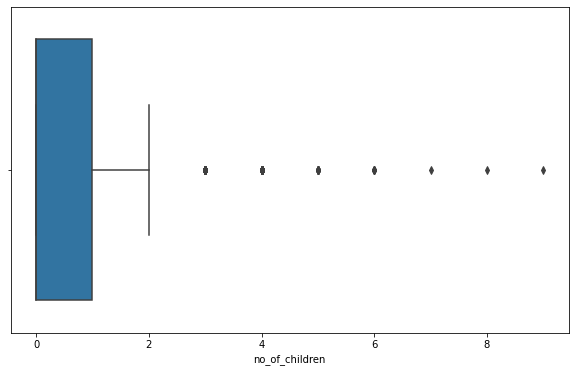

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(train_num.no_of_children)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


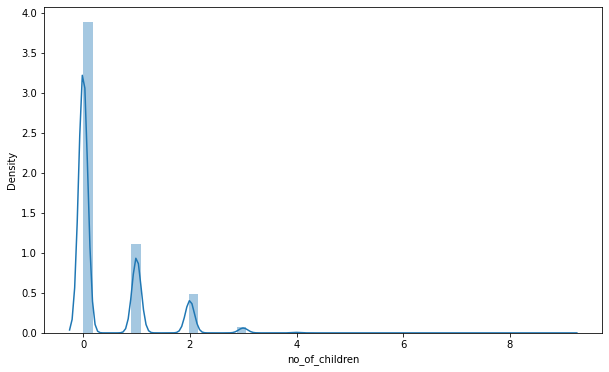

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(train_num.no_of_children)

In [ ]:
train_num['no_of_children'] = train_num['no_of_children'].fillna(train_num['no_of_children'].mode()[0])
train_num['no_of_children'].mode()[0]

0.0

In [ ]:
train_num['no_of_days_employed'] = train_num['no_of_days_employed'].fillna(train_num['no_of_days_employed'].median())

In [ ]:
train_num['total_family_members'] = train_num['total_family_members'].fillna(train_num['total_family_members'].median())

In [ ]:
train_num['migrant_worker'] = train_num['migrant_worker'].fillna(-1)

In [ ]:
train_num['yearly_debt_payments'] = train_num['yearly_debt_payments'].fillna(train_num['yearly_debt_payments'].median())

In [ ]:
train_num['credit_score'] = train_num['credit_score'].fillna(train_num['credit_score'].mode()[0])

In [ ]:
train_num.insert(loc=1, column='gender',value=train_gender_encoded)

In [ ]:
train_num.insert(loc=2, column='owns_car', value=train_car_encoded)

In [ ]:
train_num.insert(loc=3, column='owns_house', value=train_house_encoded)

In [ ]:
train_num = pd.concat([train_num, train_occ_hot_encoded], axis=1)

In [ ]:
train_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      45528 non-null  int64  
 1   gender                   45528 non-null  float64
 2   owns_car                 45528 non-null  float64
 3   owns_house               45528 non-null  float64
 4   no_of_children           45528 non-null  float64
 5   net_yearly_income        45528 non-null  float64
 6   no_of_days_employed      45528 non-null  float64
 7   total_family_members     45528 non-null  float64
 8   migrant_worker           45528 non-null  float64
 9   yearly_debt_payments     45528 non-null  float64
 10  credit_limit             45528 non-null  float64
 11  credit_limit_used(%)     45528 non-null  int64  
 12  credit_score             45528 non-null  float64
 13  prev_defaults            45528 non-null  int64  
 14  default_in_last_6month

In [ ]:
X_train_column = train_num.columns

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train = scaler.fit_transform(train_num)

In [ ]:
X_train_df = pd.DataFrame(X_train, columns=X_train_column)

In [ ]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_df, y_train, test_size=0.33, random_state=42)

In [ ]:
gender_ord_encoder = OrdinalEncoder()
test_gender_encoded = gender_ord_encoder.fit_transform(test_gender.values.reshape(-1, 1))
gender_ord_encoder.categories_

[array(['F', 'M', 'XNA'], dtype=object)]

In [ ]:
car_ord_encoder = OrdinalEncoder()
test_car_encoded = car_ord_encoder.fit_transform(test_car.values.reshape(-1, 1))
test_car_encoded[np.isnan(test_car_encoded)] = -1
car_ord_encoder.categories_

[array(['N', 'Y', nan], dtype=object)]

In [ ]:
house_ord_encoder = OrdinalEncoder()
test_house_encoded = house_ord_encoder.fit_transform(test_house.values.reshape(-1, 1))
house_ord_encoder.categories_

[array(['N', 'Y'], dtype=object)]

In [ ]:
occ_ord_encoder = OrdinalEncoder()
test_occ_encoded = occ_ord_encoder.fit_transform(test_occ.values.reshape(-1, 1))
occ_ord_encoder.categories_
len(test_occ_encoded)

11383

In [ ]:
test_occ_hot_encoded = pd.get_dummies(test_occ)
# test_occ_hot_encoded

In [ ]:
test_num['no_of_children'] = test_num['no_of_children'].fillna(test_num['no_of_children'].mode()[0])
test_num['no_of_days_employed'] = test_num['no_of_days_employed'].fillna(test_num['no_of_days_employed'].median())
test_num['total_family_members'] = test_num['total_family_members'].fillna(test_num['total_family_members'].median())
test_num['migrant_worker'] = test_num['migrant_worker'].fillna(-1)
test_num['yearly_debt_payments'] = test_num['yearly_debt_payments'].fillna(test_num['yearly_debt_payments'].median())
test_num['credit_score'] = test_num['credit_score'].fillna(test_num['credit_score'].mode()[0])

In [ ]:
test_num.insert(loc=1, column='gender',value=test_gender_encoded)
test_num.insert(loc=2, column='owns_car', value=test_car_encoded)
test_num.insert(loc=3, column='owns_house', value=test_house_encoded)
# test_num.insert(loc=7, column='occupation_type', value=test_occ_encoded)

In [ ]:
test_num = pd.concat([test_num, test_occ_hot_encoded], axis=1)

In [ ]:
test_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11383 entries, 0 to 11382
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      11383 non-null  int64  
 1   gender                   11383 non-null  float64
 2   owns_car                 11383 non-null  float64
 3   owns_house               11383 non-null  float64
 4   no_of_children           11383 non-null  float64
 5   net_yearly_income        11383 non-null  float64
 6   no_of_days_employed      11383 non-null  float64
 7   total_family_members     11383 non-null  float64
 8   migrant_worker           11383 non-null  float64
 9   yearly_debt_payments     11383 non-null  float64
 10  credit_limit             11383 non-null  float64
 11  credit_limit_used(%)     11383 non-null  int64  
 12  credit_score             11383 non-null  float64
 13  prev_defaults            11383 non-null  int64  
 14  default_in_last_6month

In [ ]:
X_test_column = test_num.columns

In [ ]:
test_scaler = MinMaxScaler()

In [ ]:
X_test = test_scaler.fit_transform(test_num)

In [ ]:
X_test_df = pd.DataFrame(X_test, columns=X_test_column)

In [ ]:
X_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11383 entries, 0 to 11382
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      11383 non-null  float64
 1   gender                   11383 non-null  float64
 2   owns_car                 11383 non-null  float64
 3   owns_house               11383 non-null  float64
 4   no_of_children           11383 non-null  float64
 5   net_yearly_income        11383 non-null  float64
 6   no_of_days_employed      11383 non-null  float64
 7   total_family_members     11383 non-null  float64
 8   migrant_worker           11383 non-null  float64
 9   yearly_debt_payments     11383 non-null  float64
 10  credit_limit             11383 non-null  float64
 11  credit_limit_used(%)     11383 non-null  float64
 12  credit_score             11383 non-null  float64
 13  prev_defaults            11383 non-null  float64
 14  default_in_last_6month

In [ ]:
svm_clf = SVC()
svm_clf.fit(X_train_split, y_train_split)
svm_pred = svm_clf.predict(X_test_split)
svm_acc = accuracy_score(y_test_split, svm_pred)
print(svm_acc)
svm_f1_score = 100*(f1_score(y_test_split, svm_pred, average='macro'))
svm_f1_score

0.9808319467554076


92.9960862767187

In [ ]:
precision_score(y_test_split, svm_pred)

1.0

In [ ]:
recall_score(y_test_split, svm_pred)

0.7703349282296651

In [ ]:
y_scores = cross_val_predict(svm_clf, X_train_split, y_train_split, cv=3, method='decision_function')

In [ ]:
precisions, recalls, thresolds = precision_recall_curve(y_train_split, y_scores)

In [ ]:
len(precisions[:-1])

7742

In [ ]:
def plot_precision_recall_vs_thresold(precisions, recalls, thresolds):
  plt.plot(thresolds, precisions[:-1], 'b--', label="Precision", linewidth=2)
  plt.plot(thresolds, recalls[:-1], "g-", label="Recall", linewidth=2)
  plt.legend(loc='center left', fontsize=16)
  plt.xlabel('Thresold', fontsize=16)
  plt.grid(True)
  

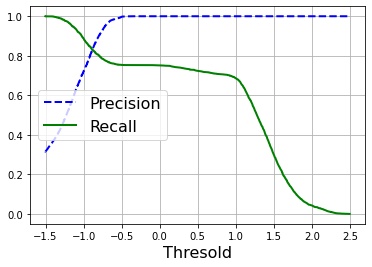

In [ ]:
plot_precision_recall_vs_thresold(precisions, recalls, thresolds)

In [ ]:
perfect_thresold = thresolds[np.argmax(precisions == recalls)]

In [ ]:
perfect_thresold

-0.8853342064356882

In [ ]:
nm = NearMiss()

In [ ]:
X_train_under, y_train_under = nm.fit_resample(X_train_df, y_train) 

In [ ]:
print(X_train_under.shape)
print(y_train_under.shape)

(7394, 34)
(7394,)


In [ ]:
X_train_under_split, X_test_under_split, y_train_under_split, y_test_under_split = train_test_split(X_train_under, y_train_under, test_size=0.33, random_state = 42)

In [ ]:
under_svm = SVC()
under_svm.fit(X_train_under_split, y_train_under_split)
under_svm_pred = under_svm.predict(X_test_under_split)
under_svm_acc = accuracy_score(y_test_under_split, under_svm_pred)
print(under_svm_acc)
under_svm_score = f1_score(y_test_under_split, under_svm_pred, average="macro")*100
print(under_svm_score)

0.8959442851290454
89.47032873570713


In [ ]:
smote = SMOTE()

In [ ]:
X_train_upper, y_train_upper = smote.fit_resample(X_train_df, y_train)

In [ ]:
print(X_train_upper.shape)
print(y_train_upper.shape)

(83662, 34)
(83662,)


In [ ]:
X_train_upper_split, X_test_upper_split, y_train_upper_split, y_test_upper_split = train_test_split(X_train_upper, y_train_upper, test_size=0.33, random_state = 42)

In [ ]:
upper_svm = SVC()
upper_svm.fit(X_train_upper_split, y_train_upper_split)
upper_svm_pred = upper_svm.predict(X_test_upper_split)
upper_svm_acc = accuracy_score(y_test_upper_split, upper_svm_pred)
print(upper_svm_acc)
upper_svm_score = f1_score(y_test_upper_split, upper_svm_pred, average="macro")*100
print(upper_svm_score)

0.9669672932739324
96.69446250586387


In [ ]:
precision_score(y_test_upper_split, upper_svm_pred)

0.9468885972788176

In [ ]:
recall_score(y_test_upper_split, upper_svm_pred)

0.9896773262109291

In [ ]:
y_score_upper = cross_val_predict(upper_svm, X_train_upper_split, y_train_upper_split, cv=3, method='decision_function')

In [ ]:
upper_pr, upper_re, upper_th = precision_recall_curve(y_train_upper_split, y_score_upper)

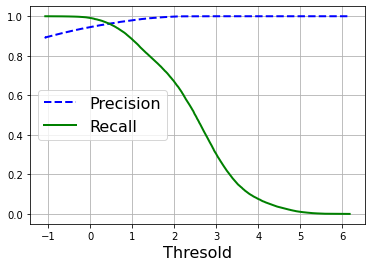

In [ ]:
plot_precision_recall_vs_thresold(upper_pr, upper_re, upper_th)

In [ ]:
# X_train.info()

# Full Dataset

In [ ]:
# print(f"train_0 %: {100*len(y_train[y_train==0])/len(y_train)}")
# print(f"train_1 %: {100*len(y_train[y_train==1])/len(y_train)}")
# print(f"test_0 %: {100*len(full_svm_pred[full_svm_pred==0])/len(X_test_df)}")
# print(f"test_1 %: {100*len(full_svm_pred[full_svm_pred==1])/len(X_test_df)}")


# full_svm = SVC()
# full_svm.fit(X_train_df, y_train)
# full_svm_pred = full_svm.predict(X_test_df)

In [ ]:
full_svm_clf = SVC()
full_svm_clf.fit(X_train_upper, y_train_upper)
full_svm_pred = full_svm_clf.predict(X_test_df)

In [ ]:
full_svm_output = pd.DataFrame({'customer_id': test_id.values, 'credit_card_default': full_svm_pred})

In [ ]:
full_svm_output.to_csv('submission_svm_upper.csv', index=False)

In [ ]:
full_svm_output

,customer_id,credit_card_default
0,CST_142525,0
1,CST_129215,0
2,CST_138443,1
3,CST_123812,0
4,CST_144450,1
...,...,...
11378,CST_142412,0
11379,CST_107967,0
11380,CST_134002,1
11381,CST_146856,0


# Rough

In [ ]:
# nn_clf = MLPClassifier(hidden_layer_sizes=(32, 32, 16, 12, 8), solver='sgd', activation='tanh', random_state=1)
# nn_clf.fit(X_train_split, y_train_split)
# nn_pred = nn_clf.predict(X_test_split)
# print(f"accXuracy: {accuracy_score(y_test_split, nn_pred)}")
# print()

In [ ]:
# hidden_layer_sizes=(32, 32, 16, 10, 4)
# hidden_layer_sizes=(32, 32, 16, 10, 8) //accuracy: 0.9808985024958403
# hidden_layer_sizes=(32, 32, 16, 12, 8) //accuracy: 0.9814309484193011

In [ ]:
# full_nn_clf = MLPClassifier(hidden_layer_sizes=(32, 32, 16, 12, 8), solver='sgd', activation='tanh')
# full_nn_clf.fit(X_train_df, y_train)
# full_nn_pred = nn_clf.predict(X_test_df)
# full_nn_pred

In [ ]:
# nn_output = pd.DataFrame({'customer_id': test_id.values, 'credit_card_default': full_nn_pred})

In [ ]:
# nn_output.to_csv('submission_32_32_16_12_8.csv', index=False)

In [ ]:
# dt_clf = DecisionTreeClassifier()
# dt_clf.fit(X_train_split, y_train_split)
# dt_pred = dt_clf.predict(X_test_split)
# dt_acc = accuracy_score(y_test_split, dt_pred)
# dt_cm = confusion_matrix(y_test_split, dt_pred)
# print(dt_acc)
# dt_cm

In [ ]:
# rf_clf = RandomForestClassifier()
# rf_clf.fit(X_train_split, y_train_split)
# rf_pred = rf_clf.predict(X_test_split)
# rf_acc = accuracy_score(y_test_split, rf_pred)
# print(rf_acc)
# rf_cm = confusion_matrix(y_test_split, rf_pred)
# rf_cm

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=10)
# knn.fit(X_train_split, y_train_split)
# knn_pred = knn.predict(X_test_split)
# print(f"accuracy: {accuracy_score(y_test_split, knn_pred)}")
# print(f"score: {100*f1_score(y_test_split, knn_pred, average='macro')}")

In [ ]:
# lr = LogisticRegression()
# lr.fit(X_train_split, y_train_split)
# lr_pred = lr.predict(X_test_split)
# print(f"accuracy: {accuracy_score(y_test_split, lr_pred)}")
# print(f"score: {100*f1_score(y_test_split, lr_pred, average='macro')}")

In [ ]:
# full_lr = LogisticRegression()
# full_lr.fit(X_train_df, y_train)
# full_lr_pred = lr.predict(X_test_df)
# print(f"accuracy: {accuracy_score(y_test_split, lr_pred)}")
# print(f"score: {100*f1_score(y_test_split, lr_pred, average='macro')}")

In [ ]:
# full_lr_output = pd.DataFrame({'customer_id': test_id.values, 'credit_card_default': full_lr_pred})

In [ ]:
# nn_output.to_csv('submission_lr.csv', index=False)

In [ ]:
# sd_scaler = StandardScaler()

In [ ]:
# X_train_scaled = sd_scaler.fit_transform(train_num)
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_column)

In [ ]:
# test_sd_scaler = StandardScaler()
# X_test_scaled = test_sd_scaler.fit_transform(test_num)
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_column)

In [ ]:
# X_train_scaled_split, X_test_scaled_split, y_train_scaled_split, y_test_scaled_split = train_test_split(X_train_scaled, y_train, test_size=0.33, random_state=42)

In [ ]:
# scaled_svm = SVC()
# scaled_svm.fit(X_train_scaled_split, y_train_scaled_split)
# scaled_svm_pred = scaled_svm.predict(X_test_scaled_split)
# acc = accuracy_score(y_test_scaled_split, scaled_svm_pred)
# print(acc)
# score = 100*(f1_score(y_test_scaled_split, scaled_svm_pred, average='macro'))
# print(score)

# Ordinal Encoded Dataset

In [ ]:
X_train_ord = X_train.copy()
X_train_ord_column = X_train.columns
X_train_ord = pd.DataFrame(X_train_ord, columns=X_train_ord_column)

In [ ]:
X_train_ord.drop(['gender', 'owns_car', 'owns_house', 'occupation_type'], axis = 1, inplace = True)

In [ ]:
X_train_ord.insert(loc=1, column='gender', value=train_gender_encoded)
X_train_ord.insert(loc=2, column='owns_car', value=train_car_encoded)
X_train_ord.insert(loc=3, column='owns_house', value=train_house_encoded)
X_train_ord.insert(loc=7, column='occupation_type', value=train_occ_encoded)

In [ ]:
X_train_ord['no_of_children'] = X_train_ord['no_of_children'].fillna(X_train_ord['no_of_children'].mode()[0])
X_train_ord['no_of_days_employed'] = X_train_ord['no_of_days_employed'].fillna(X_train_ord['no_of_days_employed'].median())
X_train_ord['total_family_members'] = X_train_ord['total_family_members'].fillna(X_train_ord['total_family_members'].median())
X_train_ord['migrant_worker'] = X_train_ord['migrant_worker'].fillna(-1)
X_train_ord['yearly_debt_payments'] = X_train_ord['yearly_debt_payments'].fillna(X_train_ord['yearly_debt_payments'].median())
X_train_ord['credit_score'] = X_train_ord['credit_score'].fillna(X_train_ord['credit_score'].mode()[0])

In [ ]:
X_train_ord_scaler = MinMaxScaler()
X_train_ord = X_train_ord_scaler.fit_transform(X_train_ord)
X_train_ord = pd.DataFrame(X_train_ord, columns=X_train_ord_column)

In [ ]:
X_train_ord.insert(loc=len(X_train_ord.columns), column='credit_card_default', value=y_train)

In [ ]:
X_train_ord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      45528 non-null  float64
 1   gender                   45528 non-null  float64
 2   owns_car                 45528 non-null  float64
 3   owns_house               45528 non-null  float64
 4   no_of_children           45528 non-null  float64
 5   net_yearly_income        45528 non-null  float64
 6   no_of_days_employed      45528 non-null  float64
 7   occupation_type          45528 non-null  float64
 8   total_family_members     45528 non-null  float64
 9   migrant_worker           45528 non-null  float64
 10  yearly_debt_payments     45528 non-null  float64
 11  credit_limit             45528 non-null  float64
 12  credit_limit_used(%)     45528 non-null  float64
 13  credit_score             45528 non-null  float64
 14  prev_defaults         

In [ ]:
X_train_ord.head()

,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,0.71875,0.0,0.5,1.0,0.0,0.000574,0.001670,0.944444,0.000000,1.0,0.094615,0.000472,0.737374,0.097996,1.0,1.0,1
1,0.18750,0.5,0.5,1.0,0.0,0.000588,0.007581,0.444444,0.111111,0.5,0.040175,0.001084,0.525253,0.795100,0.0,0.0,0
2,0.43750,0.5,0.5,1.0,0.0,0.001442,0.000553,0.444444,0.111111,0.5,0.141708,0.001208,0.434343,0.334076,0.0,0.0,0
3,0.50000,0.0,0.5,1.0,0.0,0.000676,0.032687,0.166667,0.111111,0.5,0.062407,0.000920,0.202020,0.565702,0.0,0.0,0
4,0.71875,0.5,1.0,1.0,0.0,0.002559,0.003989,0.166667,0.000000,0.5,0.110611,0.001573,0.757576,0.951002,0.0,0.0,0


In [ ]:
# X_train_ord.to_csv('train_pn.csv', index=False)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11383 entries, 0 to 11382
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      11383 non-null  int64  
 1   gender                   11383 non-null  object 
 2   owns_car                 11251 non-null  object 
 3   owns_house               11383 non-null  object 
 4   no_of_children           11193 non-null  float64
 5   net_yearly_income        11383 non-null  float64
 6   no_of_days_employed      11278 non-null  float64
 7   occupation_type          11383 non-null  object 
 8   total_family_members     11352 non-null  float64
 9   migrant_worker           11357 non-null  float64
 10  yearly_debt_payments     11361 non-null  float64
 11  credit_limit             11383 non-null  float64
 12  credit_limit_used(%)     11383 non-null  int64  
 13  credit_score             11380 non-null  float64
 14  prev_defaults         

In [ ]:
X_test_ord = test.copy()
X_test_ord_column = test.columns
X_test_ord = pd.DataFrame(X_test_ord, columns=X_test_ord_column)

In [ ]:
X_test_ord.drop(['gender', 'owns_car', 'owns_house', 'occupation_type'], axis = 1, inplace = True)

In [ ]:
X_test_ord.shape

(11383, 12)

In [ ]:
X_test_ord.insert(loc=1, column='gender', value=test_gender_encoded)
X_test_ord.insert(loc=2, column='owns_car', value=test_car_encoded)
X_test_ord.insert(loc=3, column='owns_house', value=test_house_encoded)
X_test_ord.insert(loc=7, column='occupation_type', value=test_occ_encoded)

In [ ]:
X_test_ord['no_of_children'] = X_test_ord['no_of_children'].fillna(X_test_ord['no_of_children'].mode()[0])
X_test_ord['no_of_days_employed'] = X_test_ord['no_of_days_employed'].fillna(X_test_ord['no_of_days_employed'].median())
X_test_ord['total_family_members'] = X_test_ord['total_family_members'].fillna(X_test_ord['total_family_members'].median())
X_test_ord['migrant_worker'] = X_test_ord['migrant_worker'].fillna(-1)
X_test_ord['yearly_debt_payments'] = X_test_ord['yearly_debt_payments'].fillna(X_test_ord['yearly_debt_payments'].median())
X_test_ord['credit_score'] = X_test_ord['credit_score'].fillna(X_test_ord['credit_score'].mode()[0])

In [ ]:
X_test_ord_scaler = MinMaxScaler()
X_test_ord = X_test_ord_scaler.fit_transform(X_test_ord)
X_test_ord = pd.DataFrame(X_test_ord, columns=X_test_ord_column)

In [ ]:
X_test_ord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11383 entries, 0 to 11382
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      11383 non-null  float64
 1   gender                   11383 non-null  float64
 2   owns_car                 11383 non-null  float64
 3   owns_house               11383 non-null  float64
 4   no_of_children           11383 non-null  float64
 5   net_yearly_income        11383 non-null  float64
 6   no_of_days_employed      11383 non-null  float64
 7   occupation_type          11383 non-null  float64
 8   total_family_members     11383 non-null  float64
 9   migrant_worker           11383 non-null  float64
 10  yearly_debt_payments     11383 non-null  float64
 11  credit_limit             11383 non-null  float64
 12  credit_limit_used(%)     11383 non-null  float64
 13  credit_score             11383 non-null  float64
 14  prev_defaults         

In [ ]:
# X_test_ord.to_csv('test_pn.csv', index=False)

In [ ]:
y_train_ord = X_train_ord['credit_card_default']
X_train_ord.drop(['credit_card_default'], axis=1, inplace=True)

In [ ]:
X_train_ord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      45528 non-null  float64
 1   gender                   45528 non-null  float64
 2   owns_car                 45528 non-null  float64
 3   owns_house               45528 non-null  float64
 4   no_of_children           45528 non-null  float64
 5   net_yearly_income        45528 non-null  float64
 6   no_of_days_employed      45528 non-null  float64
 7   occupation_type          45528 non-null  float64
 8   total_family_members     45528 non-null  float64
 9   migrant_worker           45528 non-null  float64
 10  yearly_debt_payments     45528 non-null  float64
 11  credit_limit             45528 non-null  float64
 12  credit_limit_used(%)     45528 non-null  float64
 13  credit_score             45528 non-null  float64
 14  prev_defaults         

In [ ]:
dt_ord = DecisionTreeClassifier()

In [ ]:
ord_pred = cross_val_predict(dt_ord, X_train_ord, y_train_ord, cv=10)

In [ ]:
ord_acc = accuracy_score(y_train_ord, ord_pred)
ord_acc*100

97.31593744508874

In [ ]:
ord_score = f1_score(y_train_ord, ord_pred, average='macro')
ord_score*100

91.04594741330358

In [ ]:
X_train_ord_sf = np.array(X_train)

In [ ]:
X_train_ord_sf

array([[46, 'F', 'N', ..., 544.0, 2, 1],
       [29, 'M', 'N', ..., 857.0, 0, 0],
       [37, 'M', 'N', ..., 650.0, 0, 0],
       ...,
       [27, 'F', 'N', ..., 727.0, 0, 0],
       [32, 'M', 'Y', ..., 805.0, 0, 0],
       [38, 'M', 'N', ..., 682.0, 0, 0]], dtype=object)

In [ ]:
X_train_ord_sf = X_train_ord.iloc[:, [6,7,10,11,12,13,14,15]]

In [ ]:
X_train_ord_sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45528 entries, 0 to 45527
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   no_of_days_employed      45528 non-null  float64
 1   occupation_type          45528 non-null  float64
 2   yearly_debt_payments     45528 non-null  float64
 3   credit_limit             45528 non-null  float64
 4   credit_limit_used(%)     45528 non-null  float64
 5   credit_score             45528 non-null  float64
 6   prev_defaults            45528 non-null  float64
 7   default_in_last_6months  45528 non-null  float64
dtypes: float64(8)
memory usage: 2.8 MB


In [ ]:
dt_ord_sf = DecisionTreeClassifier()
ord_pred_sf = cross_val_predict(dt_ord_sf, X_train_ord_sf, y_train_ord, cv=10)
ord_acc = accuracy_score(y_train_ord, ord_pred_sf)
print(ord_acc*100)
ord_score = f1_score(y_train_ord, ord_pred_sf, average='macro')
print(ord_score*100)

97.3203303461606
91.08682676008813
